In [1]:
!python --version

Python 3.11.11


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-07feb3a7-869c-405b-e83d-721c5e29a622)


In [3]:
import tensorflow as tf
print(tf.__version__)
import tf_keras as keras
import matplotlib.pyplot as plt

2.18.0


# Helper Functions

In [4]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# Data Loading

In [6]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [7]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [8]:
import os
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Data Preprocessing

In [9]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [10]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [12]:
%%time

train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 565 ms, sys: 117 ms, total: 683 ms
Wall time: 1.21 s


In [13]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [116]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

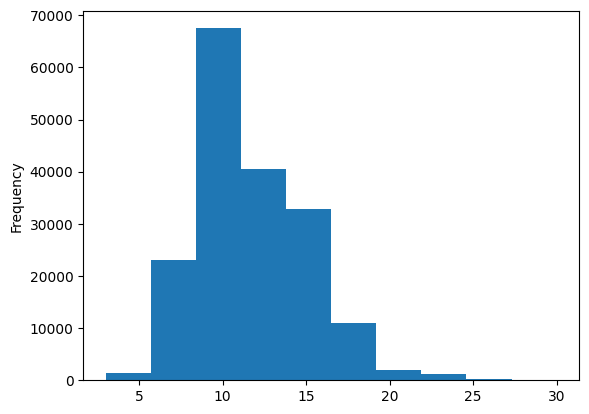

In [16]:
train_df.total_lines.plot.hist()

In [17]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df[["target"]])
val_labels_one_hot = one_hot_encoder.transform(val_df[["target"]])
test_labels_one_hot = one_hot_encoder.transform(test_df[["target"]])

In [18]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df[["target"]])
val_labels_encoded = label_encoder.transform(val_df[["target"]])
test_labels_encoded = label_encoder.transform(test_df[["target"]])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [20]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
class_names = label_encoder.classes_
num_classes = len(class_names)
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [22]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

# Model Training
- model 0: Naive bayes with TF-IDF encoder (baseline)
- model 1: Conv1D with token embeddings
- model 2: TensorFlow Hub Pretrained Feature Extractor
- model 3: Conv1D with character embeddings
- model 4: Pretrained token embeddings (same as 2) + character embeddings (same as 3)
- model 5: Pretrained token embeddings + character embeddings + positional embeddings
- model 6: Pretrained token embeddings + character embeddings + relative positional embeddings

## Model 0
Naive bayes with TF-IDF encoder (baseline)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
  ("tfidf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
evaluation_0 = model_0.score(val_sentences, val_labels_encoded)

In [25]:
baseline_preds = model_0.predict(test_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

In [26]:
results_0 = calculate_results(test_labels_encoded, baseline_preds)
results_0

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Model 1
Conv1D with token embeddings

### Token embeddings

In [27]:
sum(len(i.split()) for i in train_sentences) / len(train_sentences)

26.338269273494777

(array([4.6220e+03, 2.0864e+04, 3.5052e+04, 3.6426e+04, 2.8882e+04,
        2.0006e+04, 1.2593e+04, 7.6670e+03, 4.8980e+03, 2.6580e+03,
        2.0780e+03, 1.3590e+03, 8.9500e+02, 6.0000e+02, 4.4400e+02,
        2.9300e+02, 2.0300e+02, 1.2500e+02, 1.0000e+02, 6.5000e+01,
        4.9000e+01, 3.6000e+01, 2.6000e+01, 2.3000e+01, 1.2000e+01,
        8.0000e+00, 1.1000e+01, 4.0000e+00, 5.0000e+00, 4.0000e+00,
        3.0000e+00, 3.0000e+00, 6.0000e+00, 2.0000e+00, 5.0000e+00,
        3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,   6.9,  12.8,  18.7,  24.6,  30.5,  36.4,  42.3,  48.2,
         54.1,  60. ,  65.9,  71.8,  77.7,  83.6,  89.5,  95.4, 101.3,
        107.2, 113.1, 119. , 124.9, 130.8, 136.7, 142.6, 148.5, 154.4,
        160.3, 166.2, 172.1, 178. , 183.9, 189.8, 195.7, 201.6, 207.5,
        213.4, 219.3, 225.2, 231.1

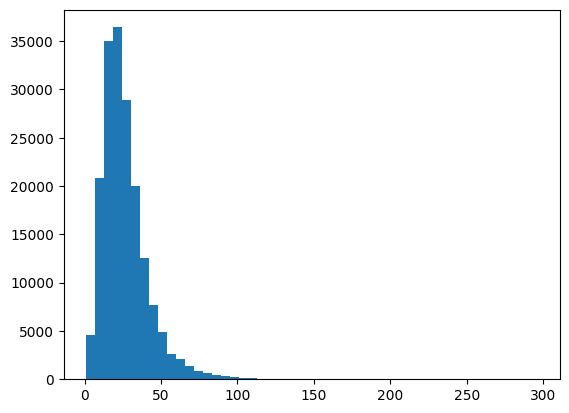

In [28]:
sent_lens = [len(i.split()) for i in train_sentences]
plt.hist(sent_lens, bins=50)

In [29]:
import numpy as np

avg_lens = np.mean(sent_lens)
avg_lens

26.338269273494777

In [30]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [31]:
from tf_keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 10000

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=output_seq_len)

text_vectorizer.adapt(train_sentences)
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 10000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 10000}

In [32]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'and', 'of']
Bottom 5 least common words: ['ethnically', 'ethambutol', 'ert', 'epicardial', 'ephedrine']


In [33]:
from tf_keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=128,
                      mask_zero=True,
                      name='token_embedding')

embedding

In [34]:
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n")

sample_tokenized = text_vectorizer([random_sentence])
print(f"Tokenized text:\n{sample_tokenized}\n")

sample_embed = embedding(sample_tokenized)
print(f"Embedded text:\n{sample_embed}")

Original text:
family outcome measures included the vanderbilt adhd diagnostic parent rating scale , parenting stress index-short form , individualized goal attainment ratings , and clinical global impression-improvement scale .

Tokenized text:
[[ 791   86  213  121    2    1 1639  712 1866  699  158 2361  401    1
   920 2721 1218 4503 1657    3   47  647    1  158    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded text:
[[[-0.03178122 -0.00280198 -0.01951825 ...  0.0113114  -0.01182814
   -0.01607753]
  [ 0.02794403 -0.03099674 -0.02907947 ...  0.02368866 -0.00568931
    0.03369528]
  [-0.01794837  0.02179698 -0.01657343 ... -0.04344753 -0.02425549
    0.03291353]
  ...
  [-0.03619496 -0.02525711  0.00963191 ...  0.03921117  0.01336446
    0.04637683]
  [-0.03619496 -0.02525711  0.00963191 ...  0.03921117  0.01336446
    0.04637683]
  [-0.03619496 -0.02525711  0.00

### Preparing the data

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset, len(train_dataset)

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 180040)

In [36]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, len(train_dataset)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 5627)

### Model building and training

In [37]:
from tf_keras import layers
input = layers.Input((1,), dtype=tf.string)
x = text_vectorizer(input)
x = embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model_1 = keras.Model(input, output)

model_1.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
history_1 = model_1.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 18s 26ms/step - loss: 0.9241 - accuracy: 0.6345 - val_loss: 0.6908 - val_accuracy: 0.7384
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6579 - accuracy: 0.7569 - val_loss: 0.6398 - val_accuracy: 0.7749
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.6170 - accuracy: 0.7731 - val_loss: 0.6002 - val_accuracy: 0.7832
Epoch 4/5
562/562 [==============================] - 6s 10ms/step - loss: 0.5883 - accuracy: 0.7879 - val_loss: 0.5809 - val_accuracy: 0.7879
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.5916 - accuracy: 0.7914 - val_loss: 0.5656 - val_accuracy: 0.7945


### Evaluation

In [39]:
evaluation_1 = model_1.evaluate(val_dataset)
evaluation_1

945/945 [==============================] - 4s 4ms/step - loss: 0.5631 - accuracy: 0.8004


[0.5630843639373779, 0.8004104495048523]

In [40]:
model_1_pred_probs = model_1.predict(test_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
results_1 = calculate_results(test_labels_encoded, model_1_preds)
results_1

942/942 [==============================] - 3s 3ms/step


{'accuracy': 79.52215032354405,
 'precision': 0.794528887195133,
 'recall': 0.7952215032354405,
 'f1': 0.7919154948483332}

In [41]:
results_0

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Model 2
TensorFlow Hub Pretrained Feature Extractor

### Feature extractor

In [42]:
import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                             input_shape=[],
                             dtype=tf.string,
                             trainable=False,
                             name='USE')

sentence_encoder_layer

### Model building and training

In [43]:
model_2 = keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

In [44]:
history_2 = model_2.fit(train_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 13s 14ms/step - loss: 0.9203 - accuracy: 0.6486 - val_loss: 0.7976 - val_accuracy: 0.6925
Epoch 2/5
562/562 [==============================] - 6s 11ms/step - loss: 0.7665 - accuracy: 0.7021 - val_loss: 0.7528 - val_accuracy: 0.7084
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7488 - accuracy: 0.7139 - val_loss: 0.7372 - val_accuracy: 0.7148
Epoch 4/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7158 - accuracy: 0.7259 - val_loss: 0.7089 - val_accuracy: 0.7324
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7224 - accuracy: 0.7234 - val_loss: 0.6900 - val_accuracy: 0.7344


### Evaluation

In [45]:
evaluation_2 = model_2.evaluate(val_dataset)
evaluation_2

945/945 [==============================] - 21s 22ms/step - loss: 0.6957 - accuracy: 0.7357


[0.6957215666770935, 0.7357341647148132]

In [46]:
model_2_pred_probs = model_2.predict(test_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
results_2 = calculate_results(test_labels_encoded, model_2_preds)
results_2

942/942 [==============================] - 17s 17ms/step


{'accuracy': 72.7957524473204,
 'precision': 0.7243408025539604,
 'recall': 0.7279575244732039,
 'f1': 0.7225994198363442}

In [47]:
results_0

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Model 3
Conv1D with character embeddings

### Character embeddings

In [48]:
def split_sentences(text):
  return " ".join(list(text))

train_chars = [split_sentences(text) for text in train_sentences]
val_chars = [split_sentences(text) for text in val_sentences]
test_chars = [split_sentences(text) for text in test_sentences]

In [49]:
chars_lens = [len(i.split()) for i in train_chars]
avg_chars_lens = np.mean(chars_lens)
avg_chars_lens

124.02798822483892

(array([1.5890e+03, 8.8780e+03, 1.9265e+04, 2.6817e+04, 2.7685e+04,
        2.6387e+04, 2.1578e+04, 1.5896e+04, 1.1123e+04, 7.1430e+03,
        4.9010e+03, 3.1950e+03, 1.9740e+03, 1.1870e+03, 8.1200e+02,
        5.3200e+02, 3.3200e+02, 2.2100e+02, 1.4500e+02, 1.0500e+02,
        6.9000e+01, 5.7000e+01, 4.4000e+01, 1.6000e+01, 2.0000e+01,
        1.5000e+01, 1.2000e+01, 9.0000e+00, 6.0000e+00, 7.0000e+00,
        5.0000e+00, 4.0000e+00, 0.0000e+00, 4.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 2.2800e+01, 4.4600e+01, 6.6400e+01, 8.8200e+01,
        1.1000e+02, 1.3180e+02, 1.5360e+02, 1.7540e+02, 1.9720e+02,
        2.1900e+02, 2.4080e+02, 2.6260e+02, 2.8440e+02, 3.0620e+02,
        3.2800e+02, 3.4980e+02, 3.7160e+02, 3.9340e+02, 4.1520e+02,
        4.3700e+02, 4.5880e+02, 4.8060e+02, 5.

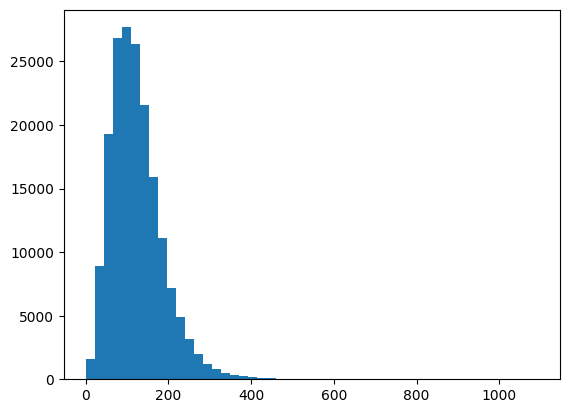

In [50]:
plt.hist(chars_lens, bins=50)

In [51]:
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

239

In [52]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation + " "

char_vectorizer = TextVectorization(max_tokens=len(alphabet)+2,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

char_vectorizer.adapt(train_chars)
char_vectorizer.get_config()

{'name': 'char_vectorizer',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 71,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 239,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 28}

In [53]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of characters in vocab: {len(char_vocab)}')
print(f'Top 5 characters in vocab: {char_vocab[:5]}')
print(f'Bottom 5 characters in vocab: {char_vocab[-5:]}')

Number of characters in vocab: 28
Top 5 characters in vocab: ['', '[UNK]', 'e', 't', 'i']
Bottom 5 characters in vocab: ['k', 'x', 'z', 'q', 'j']


In [54]:
char_embedding = Embedding(input_dim=len(char_vocab),
                           output_dim=25,
                           mask_zero=True,
                           name='char_embedding')

char_embedding

### Preparing the data

In [55]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

### Model building and training

In [56]:
input = layers.Input((1,), dtype=tf.string)
x = char_vectorizer(input)
x = char_embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation='softmax')(x)
model_3 = keras.Model(input, output)

model_3.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

In [57]:
history_3 = model_3.fit(train_char_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_char_dataset)),
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 5s 7ms/step - loss: 1.4486 - accuracy: 0.3531 - val_loss: 1.3874 - val_accuracy: 0.4142
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.3480 - accuracy: 0.4328 - val_loss: 1.3169 - val_accuracy: 0.4485
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 1.3146 - accuracy: 0.4556 - val_loss: 1.3033 - val_accuracy: 0.4515
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 1.2908 - accuracy: 0.4617 - val_loss: 1.2834 - val_accuracy: 0.4737
Epoch 5/5
562/562 [==============================] - 4s 6ms/step - loss: 1.2855 - accuracy: 0.4636 - val_loss: 1.2708 - val_accuracy: 0.4837


### Evaluation

In [58]:
evaluation_3 = model_3.evaluate(val_char_dataset)
evaluation_3

945/945 [==============================] - 3s 3ms/step - loss: 1.2722 - accuracy: 0.4790


[1.2722043991088867, 0.4789818525314331]

In [59]:
model_3_pred_probs = model_3.predict(test_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
results_3 = calculate_results(test_labels_encoded, model_3_preds)
results_3

942/942 [==============================] - 3s 3ms/step


{'accuracy': 47.23079475692716,
 'precision': 0.4298980271700623,
 'recall': 0.47230794756927164,
 'f1': 0.42906821693236363}

In [60]:
results_0

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Model 4
Pretrained token embeddings (same as 2) + character embeddings (same as 3)

### Preparing the data

In [61]:
train_combined_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, train_chars), train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_combined_dataset = tf.data.Dataset.from_tensor_slices(((val_sentences, val_chars), val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_combined_dataset = tf.data.Dataset.from_tensor_slices(((test_sentences, test_chars), test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

### Model building and training

In [62]:
# token model
token_input = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = sentence_encoder_layer(token_input)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = keras.Model(token_input, token_output)

# char model
char_input = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_input)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = keras.Model(char_input, char_bi_lstm)

# concatenate
concat = layers.Concatenate()([token_model.output, char_model.output])

# output layer
combined_dropout = layers.Dropout(0.5)(concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# construct model
model_4 = keras.Model([token_model.input, char_model.input], output_layer,
                      name='token_char_model')

model_4.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

model_4.summary()

Model: "token_char_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 239)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['token_input[0

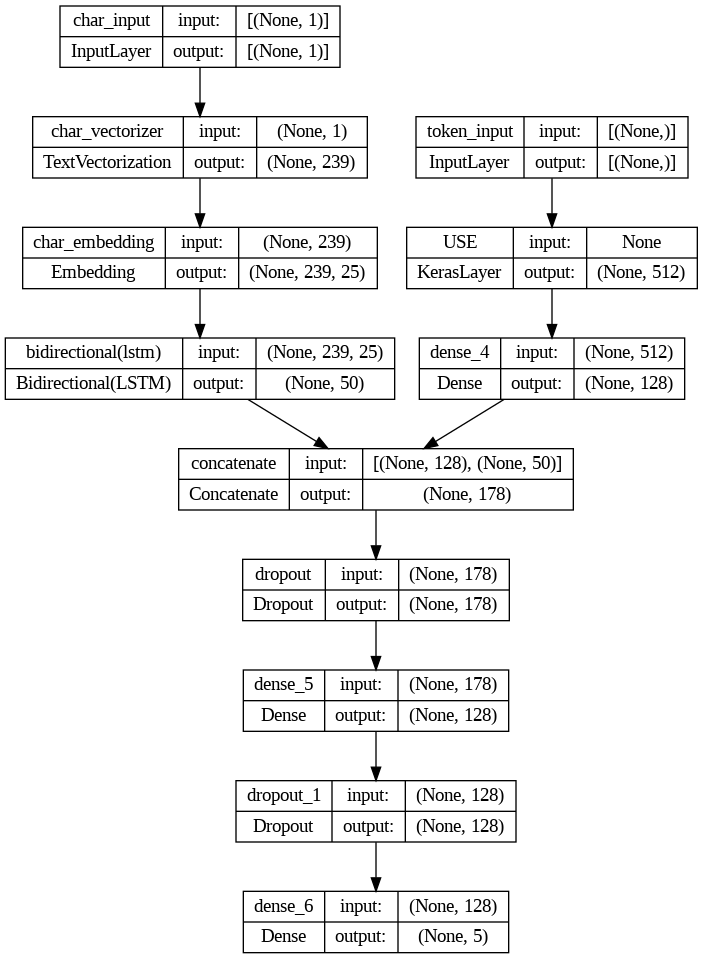

In [63]:
from tf_keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [64]:
history_4 = model_4.fit(train_combined_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_combined_dataset)),
                        validation_data=val_combined_dataset,
                        validation_steps=int(0.1*len(val_combined_dataset)))

Epoch 1/5
562/562 [==============================] - 40s 48ms/step - loss: 0.9900 - accuracy: 0.6062 - val_loss: 0.8023 - val_accuracy: 0.6898
Epoch 2/5
562/562 [==============================] - 25s 44ms/step - loss: 0.8047 - accuracy: 0.6877 - val_loss: 0.7249 - val_accuracy: 0.7264
Epoch 3/5
562/562 [==============================] - 23s 41ms/step - loss: 0.7799 - accuracy: 0.7041 - val_loss: 0.6989 - val_accuracy: 0.7271
Epoch 4/5
562/562 [==============================] - 26s 47ms/step - loss: 0.7453 - accuracy: 0.7194 - val_loss: 0.6761 - val_accuracy: 0.7497
Epoch 5/5
562/562 [==============================] - 22s 39ms/step - loss: 0.7538 - accuracy: 0.7116 - val_loss: 0.6589 - val_accuracy: 0.7483


### Evaluation

In [65]:
evaluation_4 = model_4.evaluate(val_combined_dataset)
evaluation_4

945/945 [==============================] - 18s 19ms/step - loss: 0.6663 - accuracy: 0.7455


[0.6663283705711365, 0.7454984784126282]

In [66]:
model_4_pred_probs = model_4.predict(test_combined_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
results_4 = calculate_results(test_labels_encoded, model_4_preds)
results_4

942/942 [==============================] - 21s 18ms/step


{'accuracy': 74.09988385598142,
 'precision': 0.7363204825575362,
 'recall': 0.7409988385598142,
 'f1': 0.735124880743932}

In [67]:
results_0

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Model 5
Pretrained token embeddings + character embeddings + positional embeddings*

*positional embeddings: which part of the abstract the text is located.

### Preparing the data

In [68]:
train_line_num = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_num = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_num = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_total_num = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_num = tf.one_hot(val_df['line_number'].to_numpy(), depth=20)
test_total_num = tf.one_hot(test_df['line_number'].to_numpy(), depth=20)

In [69]:
# for df in [train_df, val_df, test_df]:
#  df['scaled_position'] = df['line_number'] / df['total_lines']

### Model building and training

In [70]:
# token model
token_input = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = sentence_encoder_layer(token_input)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = keras.Model(token_input, token_output)

# char model
char_input = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_input)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = keras.Model(char_input, char_bi_lstm)

# line number model
line_number_input = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
line_number_dense = layers.Dense(32, activation='relu')(line_number_input)
line_number_model = keras.Model(line_number_input, line_number_dense)

# total line model
total_line_input = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_input")
total_line_dense = layers.Dense(32, activation='relu')(total_line_input)
total_line_model = keras.Model(total_line_input, total_line_dense)

# concatenate
concat = layers.Concatenate()([token_model.output, char_model.output])
concat = layers.Dense(256, activation='relu')(concat)
concat = layers.Dropout(0.5)(concat)

# tribrid concatenation
tribrid_concat = layers.Concatenate()([line_number_model.output,
                                      total_line_model.output,
                                      concat])


# output layer
output_layer = layers.Dense(num_classes, activation='softmax')(tribrid_concat)

# construct model
model_5 = keras.Model([line_number_model.input,
                       total_line_model.input,
                       token_model.input,
                       char_model.input],
                      output_layer,
                      name='token_char_model')

model_5.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

model_5.summary()

Model: "token_char_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 239)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['token_input[0

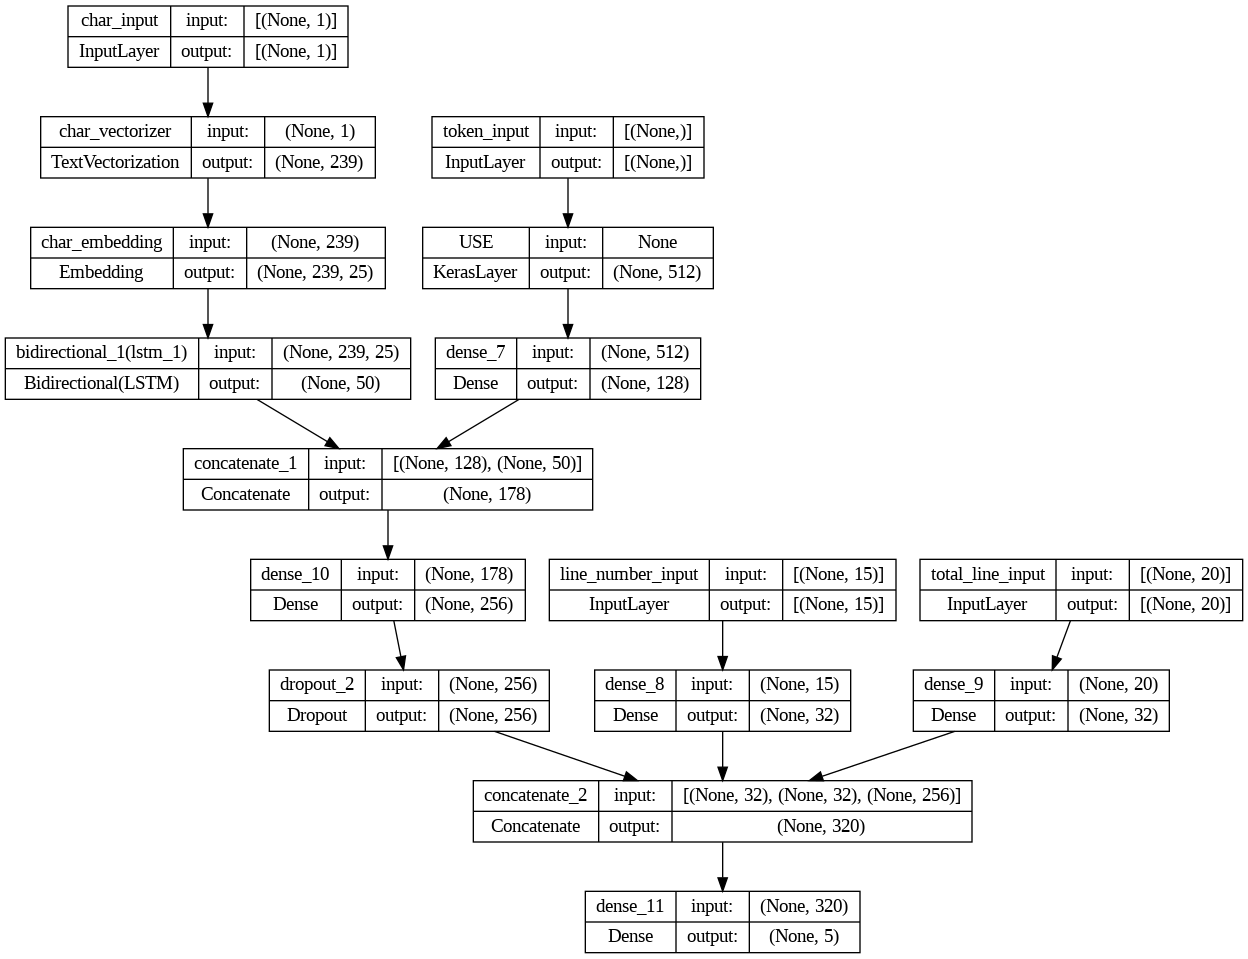

In [71]:
plot_model(model_5, show_shapes=True)

In [72]:
train_char_token_pos_dataset = tf.data.Dataset.from_tensor_slices(((train_line_num,
                                                                    train_total_num,
                                                                    train_sentences,
                                                                    train_chars),
                                                                   train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_pos_dataset = tf.data.Dataset.from_tensor_slices(((val_line_num,
                                                                  val_total_num,
                                                                  val_sentences,
                                                                  val_chars),
                                                                 val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_pos_dataset = tf.data.Dataset.from_tensor_slices(((test_line_num,
                                                                   test_total_num,
                                                                   test_sentences,
                                                                   test_chars),
                                                                  test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [73]:
history_5 = model_5.fit(train_char_token_pos_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                        validation_data=val_char_token_pos_dataset,
                        validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 37s 48ms/step - loss: 1.0985 - accuracy: 0.7230 - val_loss: 0.9903 - val_accuracy: 0.8015
Epoch 2/5
562/562 [==============================] - 24s 43ms/step - loss: 0.9684 - accuracy: 0.8151 - val_loss: 0.9670 - val_accuracy: 0.8115
Epoch 3/5
562/562 [==============================] - 24s 42ms/step - loss: 0.9514 - accuracy: 0.8228 - val_loss: 0.9835 - val_accuracy: 0.7949
Epoch 4/5
562/562 [==============================] - 25s 45ms/step - loss: 0.9408 - accuracy: 0.8351 - val_loss: 0.9667 - val_accuracy: 0.8082
Epoch 5/5
562/562 [==============================] - 24s 42ms/step - loss: 0.9373 - accuracy: 0.8353 - val_loss: 0.9625 - val_accuracy: 0.8142


### Evaluation

In [74]:
evaluation_5 = model_5.evaluate(val_char_token_pos_dataset)
evaluation_5

945/945 [==============================] - 18s 19ms/step - loss: 0.9574 - accuracy: 0.8183


[0.9574190974235535, 0.8183172345161438]

In [75]:
model_5_pred_probs = model_5.predict(test_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
results_5 = calculate_results(test_labels_encoded, model_5_preds)
results_5

942/942 [==============================] - 20s 18ms/step


{'accuracy': 81.51650904264145,
 'precision': 0.8179061488496957,
 'recall': 0.8151650904264145,
 'f1': 0.8118837592357988}

In [76]:
results_0

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Model 6
Pretrained token embeddings + character embeddings + relative positional embeddings*

* relative position: line no / total line no

### Preparing the data

In [77]:
for df in [train_df, val_df, test_df]:
 df['scaled_position'] = df['line_number'] / df['total_lines']

train_relative_position = tf.constant(train_df['scaled_position'].to_numpy(), dtype=tf.float32)
val_relative_position = tf.constant(val_df['scaled_position'].to_numpy(), dtype=tf.float32)
test_relative_position = tf.constant(test_df['scaled_position'].to_numpy(), dtype=tf.float32)

### Model building and training

In [78]:
# token model
token_input = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = sentence_encoder_layer(token_input)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = keras.Model(token_input, token_output)

# char model
char_input = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_input)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = keras.Model(char_input, char_bi_lstm)

# line number model
relative_position_input = layers.Input(shape=(1,), dtype=tf.float32, name="relative_position_input")
relative_position_dense = layers.Dense(32, activation='relu')(relative_position_input)
relative_position_model = keras.Model(relative_position_input, relative_position_dense)

# concatenate
concat = layers.Concatenate()([token_model.output, char_model.output])
concat = layers.Dense(256, activation='relu')(concat)
concat = layers.Dropout(0.5)(concat)

# tribrid concatenation
tribrid_concat = layers.Concatenate()([relative_position_model.output,
                                      concat])


# output layer
output_layer = layers.Dense(num_classes, activation='softmax')(tribrid_concat)

# construct model
model_6 = keras.Model([relative_position_model.input,
                       token_model.input,
                       char_model.input],
                      output_layer,
                      name='token_char_model')

model_6.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "token_char_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 239)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['token_input[0

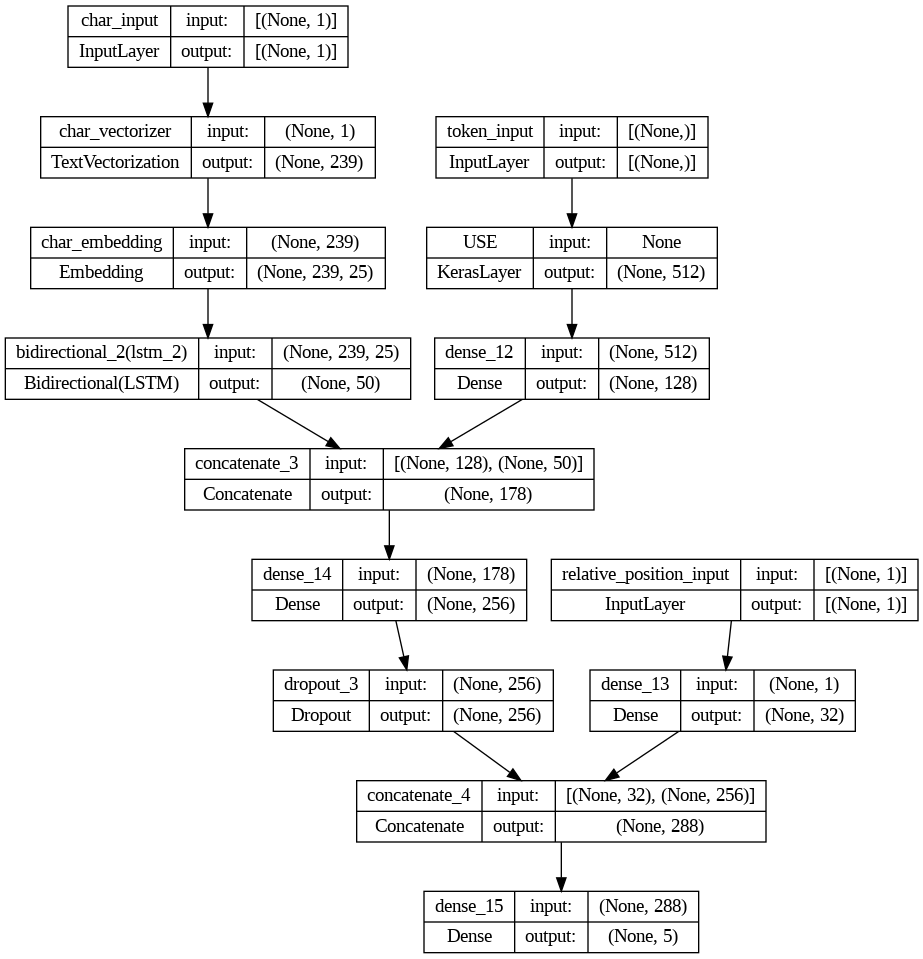

In [79]:
plot_model(model_6, show_shapes=True)

In [80]:
train_char_token_relpos_dataset = tf.data.Dataset.from_tensor_slices(((train_relative_position,
                                                                    train_sentences,
                                                                    train_chars),
                                                                   train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_relpos_dataset = tf.data.Dataset.from_tensor_slices(((val_relative_position,
                                                                  val_sentences,
                                                                  val_chars),
                                                                 val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_relpos_dataset = tf.data.Dataset.from_tensor_slices(((test_relative_position,
                                                                   test_sentences,
                                                                   test_chars),
                                                                  test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
history_6 = model_6.fit(train_char_token_relpos_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_char_token_relpos_dataset)),
                        validation_data=val_char_token_relpos_dataset,
                        validation_steps=int(0.1*len(val_char_token_relpos_dataset)))

Epoch 1/5
562/562 [==============================] - 39s 50ms/step - loss: 1.1040 - accuracy: 0.7230 - val_loss: 0.9843 - val_accuracy: 0.8105
Epoch 2/5
562/562 [==============================] - 25s 45ms/step - loss: 0.9754 - accuracy: 0.8108 - val_loss: 0.9514 - val_accuracy: 0.8305
Epoch 3/5
562/562 [==============================] - 23s 41ms/step - loss: 0.9588 - accuracy: 0.8163 - val_loss: 0.9375 - val_accuracy: 0.8411
Epoch 4/5
562/562 [==============================] - 26s 46ms/step - loss: 0.9473 - accuracy: 0.8316 - val_loss: 0.9258 - val_accuracy: 0.8398
Epoch 5/5
562/562 [==============================] - 24s 43ms/step - loss: 0.9418 - accuracy: 0.8327 - val_loss: 0.9195 - val_accuracy: 0.8457


### Evaluation

In [82]:
evaluation_6 = model_6.evaluate(val_char_token_relpos_dataset)
evaluation_6

945/945 [==============================] - 17s 19ms/step - loss: 0.9220 - accuracy: 0.8401


[0.9220150113105774, 0.8400635719299316]

In [83]:
model_6_pred_probs = model_6.predict(test_char_token_relpos_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
results_6 = calculate_results(test_labels_encoded, model_6_preds)
results_6

942/942 [==============================] - 21s 19ms/step


{'accuracy': 83.34494773519164,
 'precision': 0.8366080041100951,
 'recall': 0.8334494773519163,
 'f1': 0.8286670705412181}

In [84]:
results_0

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

# Comparison

In [85]:
all_model_results = pd.DataFrame({'model_0_baseline': results_0,
                                  'model_1_custom_token_embedding': results_1,
                                  'model_2_pretrained_token_embedding': results_2,
                                  'model_3_custom_char_embedding': results_3,
                                  'model_4_hybrid_char_token_embedding': results_4,
                                  'model_5_pos_char_token_embedding': results_5,
                                  'model_6_relative_position_embedding': results_6})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,71.667496,0.712432,0.716675,0.692510
model_1_custom_token_embedding,79.522150,0.794529,0.795222,0.791915
model_2_pretrained_token_embedding,72.795752,0.724341,0.727958,0.722599
model_3_custom_char_embedding,47.230795,0.429898,0.472308,0.429068
model_4_hybrid_char_token_embedding,74.099884,0.736320,0.740999,0.735125
model_5_pos_char_token_embedding,81.516509,0.817906,0.815165,0.811884
model_6_relative_position_embedding,83.344948,0.836608,0.833449,0.828667


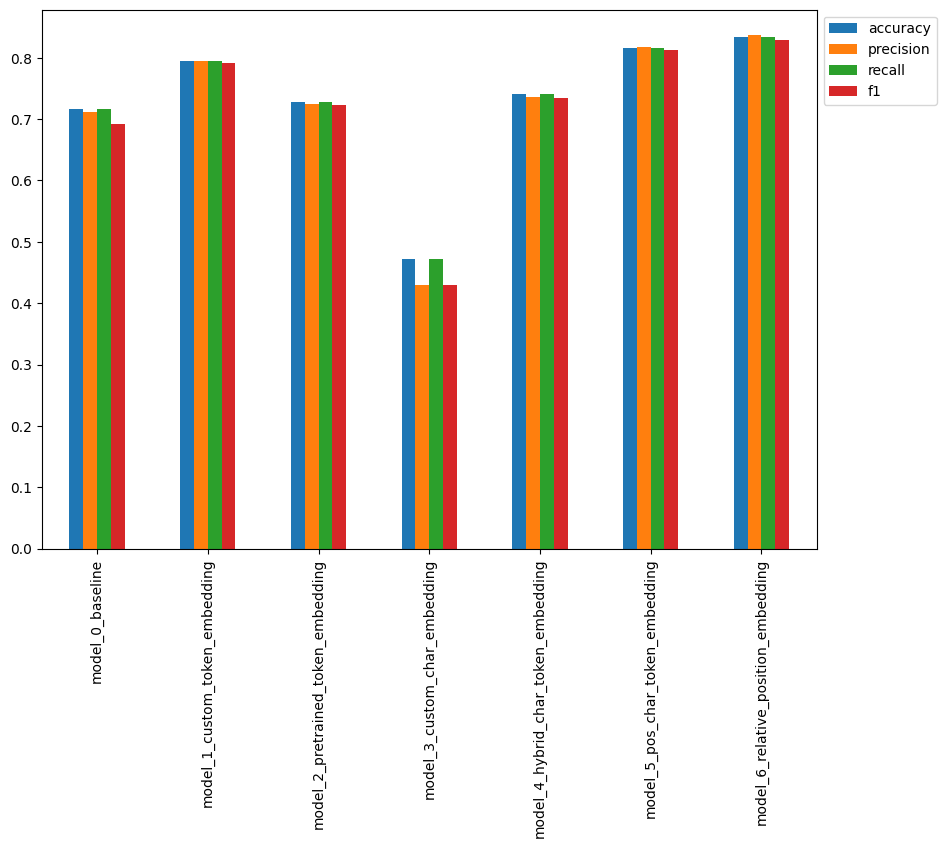

In [86]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1,1))

<Axes: >

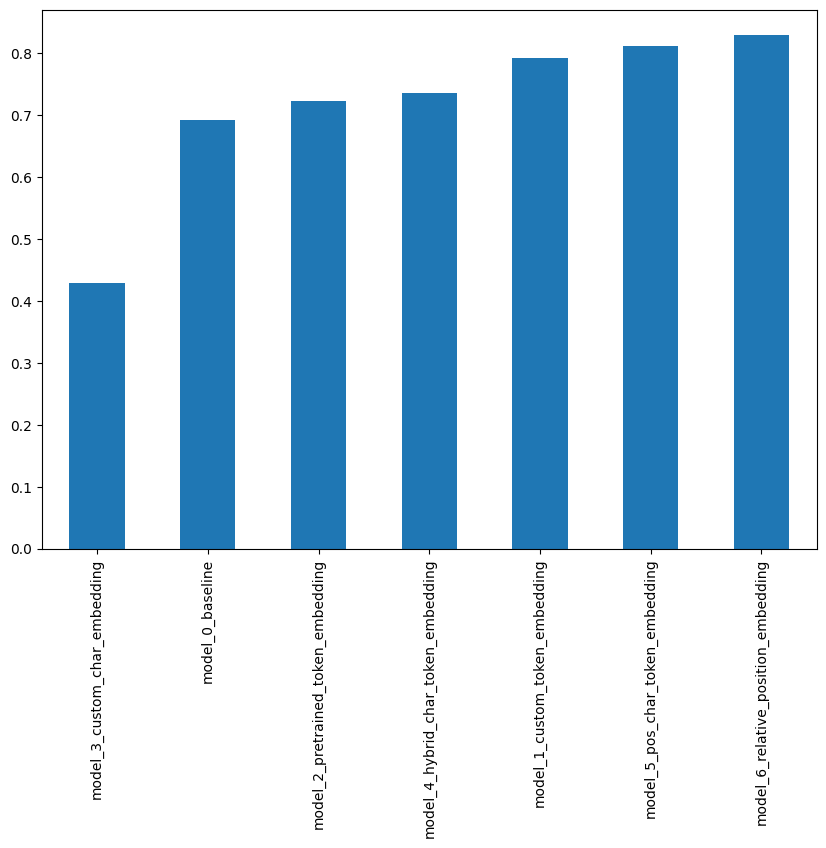

In [87]:
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize=( 10,7))

The table and the bar chart shows that model_6 is the best performing model.

# Saving the best model

In [88]:
model_6.save('pubmed_nlp')

In [89]:
loaded_model = keras.models.load_model('pubmed_nlp')

In [90]:
loaded_pred_probs = loaded_model.predict(test_char_token_relpos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_results = calculate_results(test_labels_encoded, loaded_preds)
loaded_results

942/942 [==============================] - 21s 19ms/step


{'accuracy': 83.34494773519164,
 'precision': 0.8366080041100951,
 'recall': 0.8334494773519163,
 'f1': 0.8286670705412181}

# Visualizing prediction

In [117]:
test_df['predicted_label'] = class_names[loaded_preds]

In [149]:
import random

for i in range(10):
  random_index = random.choice(test_df.index)

  print(f'Target: {test_df.loc[random_index, "target"]}')
  print(f'Predicted label: {test_df.loc[random_index, "predicted_label"]}')
  print(f'Line number: {test_df.loc[random_index, "line_number"]}/{test_df.loc[random_index, "total_lines"]}')
  print(f'Text: {test_df.loc[random_index, "text"]}\n')

Target: CONCLUSIONS
Predicted label: CONCLUSIONS
Line number: 15/16
Abstract: preliminary evidence suggests that the kyrobak may be beneficial for short-term relief of non-specific , chronic lbp , particularly in participants with a moderate level of pain .

Target: METHODS
Predicted label: METHODS
Line number: 13/19
Abstract: h-@ vs ( @ g. kg-@ .

Target: RESULTS
Predicted label: RESULTS
Line number: 7/12
Abstract: however , there was no significant between-group difference in most of the other outcomes .

Target: RESULTS
Predicted label: RESULTS
Line number: 4/9
Abstract: after approximately @ months , the seroconversion rate in @ participants was @ % .

Target: CONCLUSIONS
Predicted label: CONCLUSIONS
Line number: 12/13
Abstract: this finding supports a possible pathogenic role of melatonin neurotransmission in delirium .

Target: METHODS
Predicted label: METHODS
Line number: 1/13
Abstract: we studied data from @ patients with nasopharyngeal carcinoma ( npc ) who received radical ra